In [1]:
"""
Train the InceptionV3 models and test running inference. In this document, running inference is only to test some code.
The model evaluations are done in Evaluate_models.ipynb.

Authors: Paul Rosero & Booy Faassen
"""

import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.applications.inception_v3 import InceptionV3
import psutil

In [2]:
#Define some parameters for the loader:
batch_size = 32
img_height = 299
img_width = 299
root_dir = './data'
class_names=["0.0", "1.0"]

In [3]:
""" Loading the data """

def split_train_test_set(dataset):
    train_dir=root_dir +"/" + dataset +"/" + "train"
    test_dir=root_dir + "/" + dataset +"/" + "test"
    # Import data from directories and turn it into batches
    train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                     labels='inferred',
                                                                     seed=123,
                                                                     label_mode="categorical",
                                                                     color_mode='rgb',
                                                                     batch_size=batch_size, 
                                                                     image_size=(img_height, img_width) 
                                                                    )

    test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                    labels='inferred',
                                                                    seed=123,
                                                                    label_mode="categorical",
                                                                    color_mode='rgb',
                                                                    batch_size=batch_size, 
                                                                    image_size=(img_height, img_width)  
                                                                   )
    return train_data, test_data

In [4]:
img_augmentation = tf.keras.models.Sequential(
    [
        tf.keras.layers.Normalization(axis=-1, mean=None, variance=None, invert=False),
        tf.keras.layers.RandomRotation(factor=0.15),
        tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        tf.keras.layers.RandomFlip(),
        tf.keras.layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

"""
A pre-processing step without augmentation
"""

pre_processing = tf.keras.models.Sequential(
    [
        tf.keras.layers.Normalization(axis=-1, mean=0, variance=1, invert=False)
    ],
    name="pre_processing",
)

In [5]:
""" Set metrics for later use """

METRICS = [
    tf.keras.metrics.Accuracy(name='acc'),
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.BinaryAccuracy(name='Binary accuracy'),
    tf.keras.metrics.CategoricalAccuracy(name='Categorical accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

In [6]:
""" Build the InceptionV3 model """

def build_model(num_classes, aprov_pre, modify_top=False, metrics=METRICS):
    inputs = tf.keras.layers.Input(shape=(img_height,img_width,3))
    inputs_re = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./127.5, offset=-1)(inputs)
    if aprov_pre==True:
        y = img_augmentation(inputs_re)
        model_input=InceptionV3(include_top=False, weights="imagenet" ,input_tensor=y)
        print("preprocessing:",aprov_pre)
    else:
        y = pre_processing(inputs_re)
        model_input=InceptionV3(include_top=False, weights="imagenet" ,input_tensor=y)
        print("preprocessing:",aprov_pre)
        
    # Freeze the pretrained weights
    model_input.trainable = False
    # add a global spatial average pooling layer
    x = model_input.output
    
    if not modify_top:
        x = tf.keras.layers.Flatten()(x) # should be removed if using global average pooling for compatibility.
    
    if modify_top:
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(1024, activation='relu')(x) #fully-connected layer
        
    predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    # this is the model we will train
    model = tf.keras.models.Model(y, predictions)
    # compile the model (should be done *after* setting layers to non-trainable)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(optimizer, loss='categorical_crossentropy', metrics=metrics)
    return model

In [7]:
""" Plotting """

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [8]:
def unfreeze_model(model, num, metrics=METRICS):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    # we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
# for layer in model.layers[:249]:
#    layer.trainable = False
# for layer in model.layers[249:]:
#    layer.trainable = True
    for layer in model.layers[num:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=metrics
    )

In [9]:
dataset="dataset02"
num_epochs=10

In [15]:
"""
Training. It trains x number of models where x = the number of epochs.
In the below, last 20 layers are unfrozen and the top is modified.
"""

train_data, test_data=split_train_test_set(dataset)
model = build_model(num_classes=2, aprov_pre=False, modify_top=False, metrics=METRICS)
#unfreeze_model(model, 20)
start=datetime.now()
hist_m = model.fit(train_data,
            epochs=num_epochs,
            steps_per_epoch=None,
            validation_data=test_data,
            # Go through less of the validation data so epochs are faster (we want faster experiments!)
            validation_steps=int(0.25 * len(test_data)),
            verbose=1 )
end=datetime.now()

# find difference loop start and end time and display
td= (end-start)
print("----------------- MODEL----------------------------")
print(f"The time of execution of above program is : {td}ms")
# Calling psutil.cpu_precent()for 4 seconds
print('The CPU usage is: ', psutil.cpu_times_percent(5))
# Getting % usage of virtual_memory ( 3rd field)
print('RAM memory % used:', psutil.virtual_memory()[2])
# Getting usage of virtual_memory in GB ( 4th field)
print('RAM Used (GB):',psutil.virtual_memory()[3]/1000000000)
print("---------------------------------------------------")
plot_hist(hist_m)

Found 806 files belonging to 2 classes.
Found 268 files belonging to 2 classes.
preprocessing: False
Epoch 1/10
26/26 [==============================] - 268s 9s/step - loss: 134565.1875 - acc: 0.5537 - tp: 481.0000 - fp: 357.0000 - tn: 481.0000 - fn: 357.0000 - Binary accuracy: 0.5740 - Categorical accuracy: 0.5740 - precision: 0.5740 - recall: 0.5740 - val_loss: 21268.8477 - val_acc: 0.3906 - val_tp: 25.0000 - val_fp: 39.0000 - val_tn: 25.0000 - val_fn: 39.0000 - val_Binary accuracy: 0.3906 - val_Categorical accuracy: 0.3906 - val_precision: 0.3906 - val_recall: 0.3906
Epoch 2/10
26/26 [==============================] - 235s 9s/step - loss: 26151.5430 - acc: 0.5763 - tp: 465.0000 - fp: 341.0000 - tn: 465.0000 - fn: 341.0000 - Binary accuracy: 0.5769 - Categorical accuracy: 0.5769 - precision: 0.5769 - recall: 0.5769 - val_loss: 21696.5840 - val_acc: 0.6719 - val_tp: 43.0000 - val_fp: 21.0000 - val_tn: 43.0000 - val_fn: 21.0000 - val_Binary accuracy: 0.6719 - val_Categorical accuracy: 

KeyboardInterrupt: 

In [178]:
""" History from model.fit(), i.e., the training results """

#print(hist_m.history)
      
print('loss:', hist_m.history['loss'][0])
print('acc:', hist_m.history['acc'][0])
print('true positives:', hist_m.history['tp'][0])
print('false positives:', hist_m.history['fp'][0])
print('true negatives:', hist_m.history['tn'][0])
print('false negatives:', hist_m.history['fn'][0])
print('accuracy:', hist_m.history['accuracy'][0])
print('precision:', hist_m.history['precision'][0])
print('recall:', hist_m.history['recall'][0])

print("total classifications:", hist_m.history['tp'][0] + hist_m.history['fp'][0] + hist_m.history['tn'][0] + hist_m.history['fn'][0])



loss: 16468.515625
acc: 0.6244286298751831
true positives: 1231.0
false positives: 738.0
true negatives: 1231.0
false negatives: 738.0
accuracy: 0.6251904368400574
precision: 0.6251904368400574
recall: 0.6251904368400574
auc: 0.6251904964447021
prc: 0.5963938236236572
total classifications: 3938.0


In [179]:
model.save('./saved_models/InceptionV3') # this creates a SavedModel object, good for TensorFlow Lite

INFO:tensorflow:Assets written to: ./saved_models/InceptionV3_2ndAttempt\assets


INFO:tensorflow:Assets written to: ./saved_models/InceptionV3_2ndAttempt\assets


In [2]:
"""
Load models from file into memory
"""

loaded_model = tf.keras.models.load_model('./saved_models/InceptionV3_2ndAttempt')

#loaded_model.summary()


In [13]:
"""
evaluate: i.e. run inference on the test set.
"""

results = loaded_model.evaluate(
    x = test_data,
    batch_size = 32,
    verbose=1
)

NameError: name 'test_data' is not defined

In [ ]:
print(results)

1/1 - 7s - 7s/epoch - 7s/step
1.0: broken. 0.0: whole


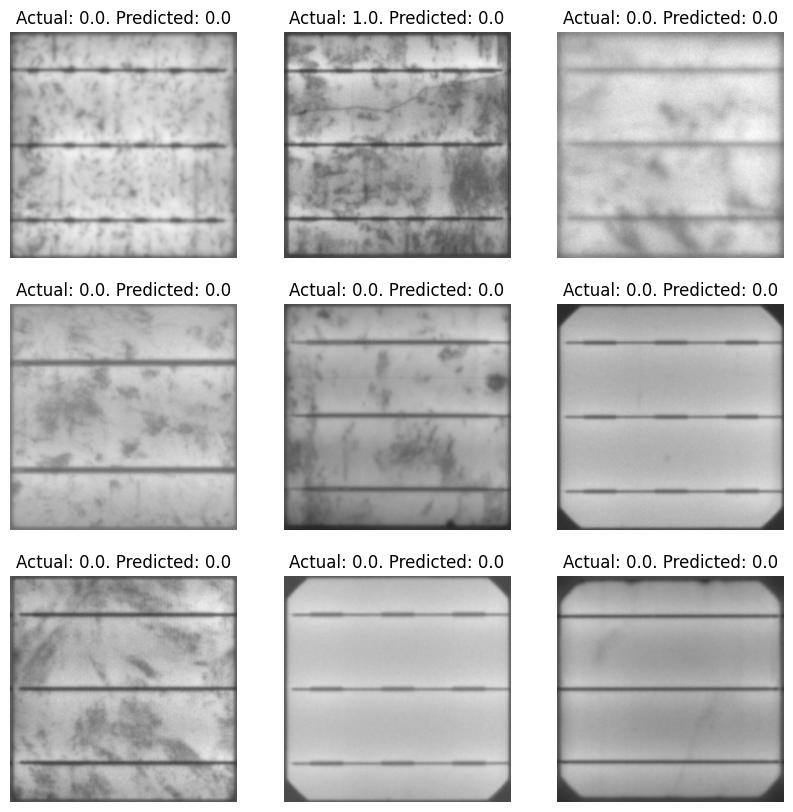

In [190]:
""" Visualize actual label vs prediction """

image_batch, label_batch = next(iter(test_data))

predictions = loaded_model.predict(image_batch, verbose=2)

print("1.0: broken. 0.0: whole")

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = int(label_batch[i][1].numpy())
    title = "Actual: "  + class_names[label] + ". Predicted: " + str(predictions[i][1])
    plt.title(title)
    plt.axis("off")

#print(predictions)